In [43]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import numpy as np

import os
import copy
import time

import matplotlib.pyplot as plt

In [2]:
c_path = os.getcwd()

In [3]:
data_directory = c_path+"/Intel Image Classification"

In [4]:
data_transforms = {
    'seg_train': transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'seg_test': transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_directory, x), data_transforms[x]) for x in ['seg_train', 'seg_test']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=4) for x in ['seg_train', 'seg_test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['seg_train', 'seg_test']}
class_names = image_datasets['seg_train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Building CNN!

In [6]:
class Img_clf(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*28*28, 64)
        self.fc2 = nn.Linear(64, 6)
        
    def forward(self, x):
        out = F.relu(F.max_pool2d(self.conv1(x),2))
        out = F.relu(F.max_pool2d(self.conv2(out),2))
        out = F.relu(F.max_pool2d(self.conv3(out),2))
        out = out.view(-1, 128*28*28)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [8]:
model = Img_clf()
model.to(device)

Img_clf(
  (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['seg_train', 'seg_test']:
            if phase == 'seg_train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'seg_train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'seg_train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'seg_test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
trained_model = train_model(model, criterion, optimizer,
                       num_epochs=25)

Epoch 0/24
----------
seg_train Loss: 1.2016 Acc: 0.5264
seg_test Loss: 0.9255 Acc: 0.6447

Epoch 1/24
----------
seg_train Loss: 1.0091 Acc: 0.6122
seg_test Loss: 0.7237 Acc: 0.7423

Epoch 2/24
----------
seg_train Loss: 0.8599 Acc: 0.6720
seg_test Loss: 0.6629 Acc: 0.7583

Epoch 3/24
----------
seg_train Loss: 0.7765 Acc: 0.7123
seg_test Loss: 0.5845 Acc: 0.7987

Epoch 4/24
----------
seg_train Loss: 0.7462 Acc: 0.7238
seg_test Loss: 0.5423 Acc: 0.8123

Epoch 5/24
----------
seg_train Loss: 0.7186 Acc: 0.7304
seg_test Loss: 0.5116 Acc: 0.8133

Epoch 6/24
----------
seg_train Loss: 0.7086 Acc: 0.7355
seg_test Loss: 0.5412 Acc: 0.8057

Epoch 7/24
----------
seg_train Loss: 0.6902 Acc: 0.7462
seg_test Loss: 0.4882 Acc: 0.8243

Epoch 8/24
----------
seg_train Loss: 0.6655 Acc: 0.7545
seg_test Loss: 0.5272 Acc: 0.8167

Epoch 9/24
----------
seg_train Loss: 0.6665 Acc: 0.7490
seg_test Loss: 0.5225 Acc: 0.8113

Epoch 10/24
----------
seg_train Loss: 0.6375 Acc: 0.7611
seg_test Loss: 0.5215 

### Transfer Learning

In [14]:
transfer_model = models.resnet34(pretrained=True)
for name, param in transfer_model.named_parameters():
    if ('bn' not in name):
        param.requires_grad = False

In [15]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 500), nn.ReLU(), nn.Dropout(), nn.Linear(500, 6))

In [18]:
### Pretrained Model
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.01)
transfer_model.to(device)
trained_tl_model = train_model(transfer_model, criterion, optimizer,
                       num_epochs=20)

Epoch 0/19
----------
seg_train Loss: 0.9581 Acc: 0.6778
seg_test Loss: 0.4354 Acc: 0.8673

Epoch 1/19
----------
seg_train Loss: 0.7065 Acc: 0.7618
seg_test Loss: 0.3783 Acc: 0.8657

Epoch 2/19
----------
seg_train Loss: 0.6221 Acc: 0.7895
seg_test Loss: 0.3444 Acc: 0.8870

Epoch 3/19
----------
seg_train Loss: 0.5769 Acc: 0.8023
seg_test Loss: 0.3180 Acc: 0.8963

Epoch 4/19
----------
seg_train Loss: 0.5725 Acc: 0.7998
seg_test Loss: 0.4092 Acc: 0.8603

Epoch 5/19
----------
seg_train Loss: 0.5580 Acc: 0.8107
seg_test Loss: 0.3197 Acc: 0.8953

Epoch 6/19
----------
seg_train Loss: 0.5332 Acc: 0.8101
seg_test Loss: 0.3283 Acc: 0.8950

Epoch 7/19
----------
seg_train Loss: 0.5159 Acc: 0.8244
seg_test Loss: 0.3438 Acc: 0.8900

Epoch 8/19
----------
seg_train Loss: 0.5198 Acc: 0.8210
seg_test Loss: 0.3087 Acc: 0.8987

Epoch 9/19
----------
seg_train Loss: 0.5082 Acc: 0.8247
seg_test Loss: 0.4055 Acc: 0.8703

Epoch 10/19
----------
seg_train Loss: 0.5073 Acc: 0.8268
seg_test Loss: 0.2927 

In [28]:
data_test_transform = {
    'seg_pred': transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [33]:
image_test = {x: torchvision.datasets.ImageFolder(os.path.join(data_directory, x), data_test_transform[x]) for x in ['seg_pred']}
data_test = {x: torch.utils.data.DataLoader(image_test[x], batch_size=10,
                                              shuffle=True, num_workers=4) for x in ['seg_pred']}

dataset_sizes = {x: len(image_test[x]) for x in ['seg_pred']}


In [34]:
model.eval()   # Set model to evaluate mode
for inputs, labels in data_test["seg_pred"]:
    inputs = inputs.to(device)
    outputs = trained_tl_model(inputs)
    _, preds = torch.max(outputs, 1)
    print(preds)
    break

tensor([0, 0, 5, 4, 5, 2, 5, 0, 1, 1], device='cuda:0')


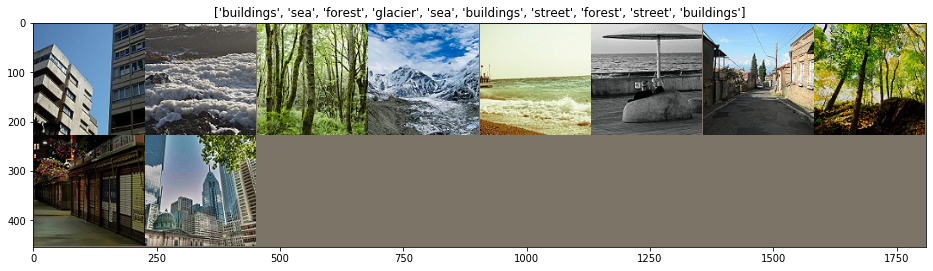

In [60]:
trained_model.to('cpu')
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_test['seg_pred']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#inputs = inputs#.to(device)
outputs = trained_model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(16,16))
imshow(out, title=[class_names[x] for x in preds])

### Prediction from Transfer Learning

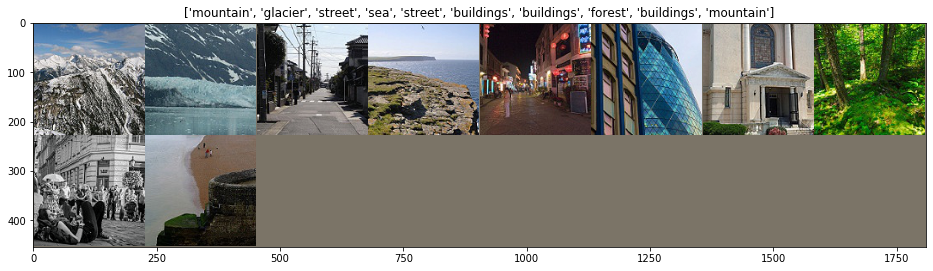

In [59]:
trained_tl_model.to('cpu')
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_test['seg_pred']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#inputs = inputs#.to(device)
outputs = trained_tl_model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(16,16))
imshow(out, title=[class_names[x] for x in preds])